# 1. Выбор и обоснование данных
В качестве выборок данных были взяты данные об авиарейсах в штате **Аляска** (*Международный аэропорт Анкоридж имени Теда Стивенса*) и в штате **Техас** (*Международный аэропорт Даллас/Форт-Уэрт*). Рассматриваемый период: January, 2020 - December, 2024. Конкретно рассматриваются данные о задержке рейсов. Изначально данные содержат информацию о времени задержке и причине, но нас будет интересовать только количество, поэтому данные преобразуются.

**Связь:** данные об авиаперелетах в обоих случаях, аэропорты находятся в одной стране.

**Ключевое различие:** Аляска и Техас имеют различные климатические условия: Аляска является самым северным штатом США, а Техас относится к южным. Это может влиять на количество задержек.

**Ожидание:** В Техасе количество задержек будет стабильно выше, поскольку аэропорт обслуживает больше рейсов, что увеличивает вероятность операционных задержек. В Аляске, напротив, количество задержек будет менее предсказуемым и сильнее варьироваться из-за погодных условий.

Источник данных: https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp?20=E&fry=N&Nv42146=QSj&Nv42146_anzr=Qnyyn5/S146%20j146u,%20gk:%20Qnyyn5/S146%20j146u%20V06r40n6v10ny

In [ ]:
import pandas as pd

In [ ]:
alyaska_path = "/alyaska.csv"
texas_path = "/texas.csv"

In [ ]:
a_data = pd.read_csv(alyaska_path)
t_data = pd.read_csv(texas_path)

# Фильтруем данные:

In [ ]:
# Создание столбца даты
a_data["date"] = a_data["year"].astype(str) + "-" + a_data["month"].astype(str).str.zfill(2)
t_data["date"] = t_data["year"].astype(str) + "-" + t_data["month"].astype(str).str.zfill(2)

# Определение задержки (1 - задержан, 0 - не задержан)
a_data["delayed"] = (a_data["arr_del15"] >= 1).astype(int)
t_data["delayed"] = (t_data["arr_del15"] >= 1).astype(int)

# Группируем и суммируем задержки по месяцам
a_delayed_counts = a_data.groupby("date", as_index=False)["delayed"].sum()
t_delayed_counts = t_data.groupby("date", as_index=False)["delayed"].sum()

# Сохранение обработанных данных
a_delayed_counts.to_csv("a_data.csv", index=False)
t_delayed_counts.to_csv("t_data.csv", index=False)


In [ ]:
import numpy as np
from scipy.stats import skew

# 2. Первичный статистический анализ

Оформим одной функцией:

In [ ]:
def calculate_statistics(df, name):
    delayed_flights = df["delayed"]

    stats = {
        "Минимум": delayed_flights.min(),
        "Максимум": delayed_flights.max(),
        "Размах": delayed_flights.max() - delayed_flights.min(),
        "Математическое ожидание": delayed_flights.mean(),
        "Дисперсия": delayed_flights.var(),
        "Стандартное отклонение": delayed_flights.std(),
        "Коэффициент асимметрии": skew(delayed_flights),
        "Медиана": delayed_flights.median(),
        "Первый квартиль (Q1)": delayed_flights.quantile(0.25),
        "Третий квартиль (Q3)": delayed_flights.quantile(0.75),
        "Интерквартильная широта (IQR)": delayed_flights.quantile(0.75) - delayed_flights.quantile(0.25)
    }

    print(f"Статистика для {name}:\n")
    for key, value in stats.items():
        print(f"{key}: {value}")
    print("-" * 40)

In [ ]:
calculate_statistics(a_delayed_counts, "Аляска")
calculate_statistics(t_delayed_counts, "Техас")

Статистика для Аляска:

Минимум: 2
Максимум: 6
Размах: 4
Математическое ожидание: 4.483333333333333
Дисперсия: 0.6607344632768344
Стандартное отклонение: 0.8128557456749841
Коэффициент асимметрии: -0.7096968056333446
Медиана: 5.0
Первый квартиль (Q1): 4.0
Третий квартиль (Q3): 5.0
Интерквартильная широта (IQR): 1.0
----------------------------------------
Статистика для Техас:

Минимум: 11
Максимум: 14
Размах: 3
Математическое ожидание: 11.7
Дисперсия: 0.5525423728813555
Стандартное отклонение: 0.7433319399039406
Коэффициент асимметрии: 0.7890191757065099
Медиана: 12.0
Первый квартиль (Q1): 11.0
Третий квартиль (Q3): 12.0
Интерквартильная широта (IQR): 1.0
----------------------------------------


# 3. Графики

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [ ]:
sns.set_style("whitegrid")

In [ ]:
a_data = a_delayed_counts
t_data = t_delayed_counts

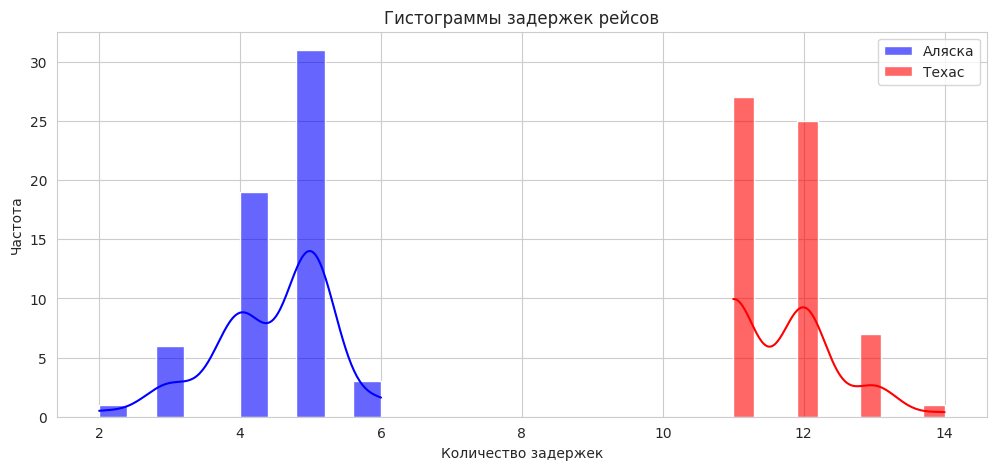

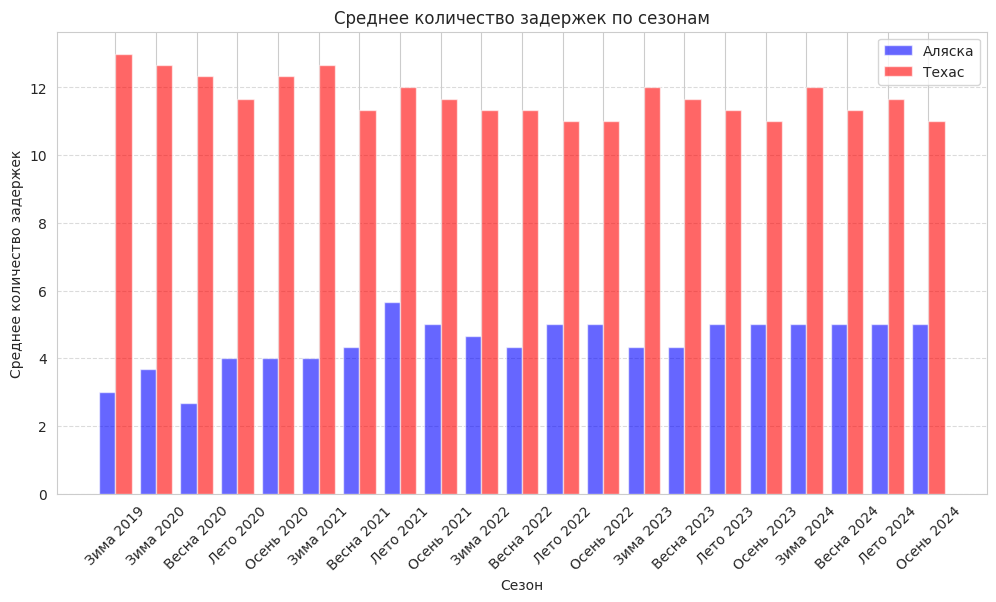

In [ ]:
# 1. Гистограммы

# Гистограмма частоты задержек
plt.figure(figsize=(12, 5))
sns.histplot(a_data["delayed"], bins=10, kde=True, color="blue", label="Аляска", alpha=0.6)
sns.histplot(t_data["delayed"], bins=10, kde=True, color="red", label="Техас", alpha=0.6)
plt.xlabel("Количество задержек")
plt.ylabel("Частота")
plt.title("Гистограммы задержек рейсов")
plt.legend()
plt.show()

# График задержек по времени
def get_season(date_str):
    year, month = map(int, date_str.split("-"))
    if month in [12, 1, 2]:
        return f"Зима {year if month == 12 else year - 1}"
    elif month in [3, 4, 5]:
        return f"Весна {year}"
    elif month in [6, 7, 8]:
        return f"Лето {year}"
    else:
        return f"Осень {year}"

a_seasonal_data = a_data.copy()
t_seasonal_data = t_data.copy()

a_seasonal_data["season"] = a_seasonal_data["date"].apply(get_season)
t_seasonal_data["season"] = t_seasonal_data["date"].apply(get_season)

# Группируем данные по сезонам
a_season_avg = a_seasonal_data.groupby("season")["delayed"].mean().reset_index()
t_season_avg = t_seasonal_data.groupby("season")["delayed"].mean().reset_index()

def season_sort_key(season):
    season_name, year = season.split()
    year = int(year)
    order = {"Зима": 0, "Весна": 1, "Лето": 2, "Осень": 3}
    return (year, order[season_name])

unique_seasons = sorted(a_season_avg["season"].unique(), key=season_sort_key)


season_positions = {season: i for i, season in enumerate(unique_seasons)}
a_season_avg["x_pos"] = a_season_avg["season"].map(season_positions)
t_season_avg["x_pos"] = t_season_avg["season"].map(season_positions)

plt.figure(figsize=(12, 6))

bar_width = 0.4
plt.bar(a_season_avg["x_pos"] - bar_width/2, a_season_avg["delayed"], color="blue", alpha=0.6, width=bar_width, label="Аляска")
plt.bar(t_season_avg["x_pos"] + bar_width/2, t_season_avg["delayed"], color="red", alpha=0.6, width=bar_width, label="Техас")

plt.xticks(ticks=list(season_positions.values()), labels=unique_seasons, rotation=45)
plt.xlabel("Сезон")
plt.ylabel("Среднее количество задержек")
plt.title("Среднее количество задержек по сезонам")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

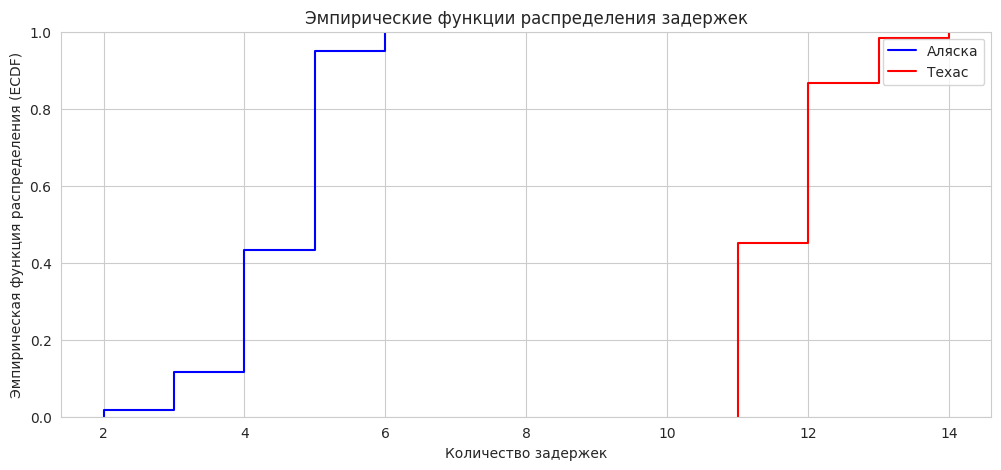

In [ ]:
# 2. Эмпирические функции распределения (ECDF)
plt.figure(figsize=(12, 5))
sns.ecdfplot(a_data["delayed"], label="Аляска", color="blue")
sns.ecdfplot(t_data["delayed"], label="Техас", color="red")
plt.xlabel("Количество задержек")
plt.ylabel("Эмпирическая функция распределения (ECDF)")
plt.title("Эмпирические функции распределения задержек")
plt.legend()
plt.show()

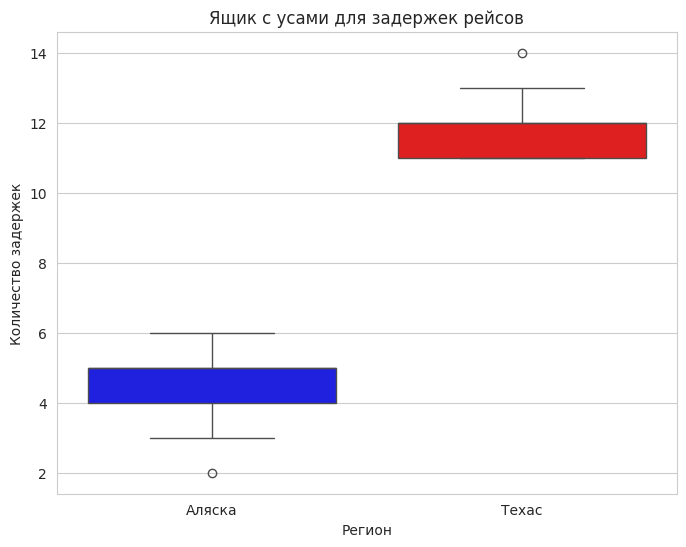

In [ ]:
# 3. Boxplot
# Создаем DataFrame
df = pd.DataFrame({
    "Задержки": list(a_data["delayed"]) + list(t_data["delayed"]),
    "Регион": ["Аляска"] * len(a_data) + ["Техас"] * len(t_data)
})

# Строим
plt.figure(figsize=(8, 6))
sns.boxplot(x="Регион", y="Задержки", data=df, hue="Регион",
            palette={"Аляска": "blue", "Техас": "red"}, legend=False)

plt.ylabel("Количество задержек")
plt.title("Ящик с усами для задержек рейсов")
plt.show()

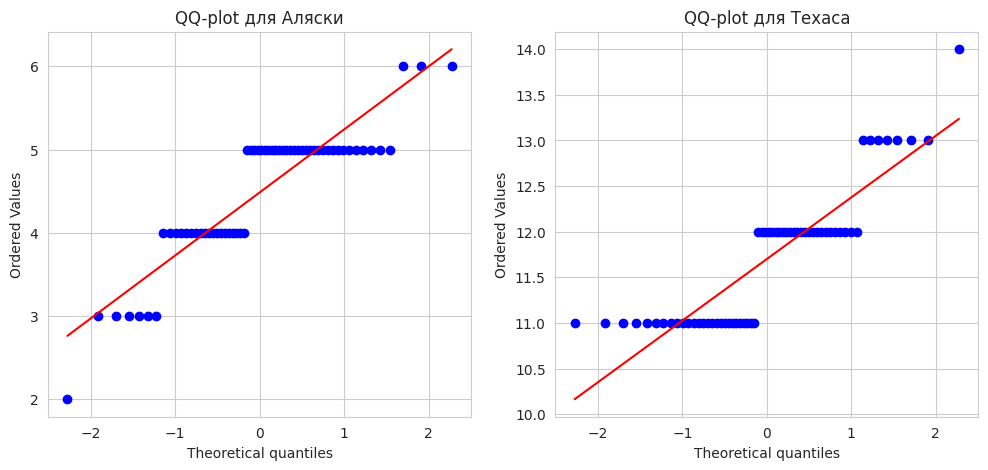

In [ ]:
# 4. QQ-plot (для проверки нормальности распределения)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

stats.probplot(a_data["delayed"], dist="norm", plot=axes[0])
axes[0].set_title("QQ-plot для Аляски")

stats.probplot(t_data["delayed"], dist="norm", plot=axes[1])
axes[1].set_title("QQ-plot для Техаса")

plt.show()

# **Сравнительный анализ для численных данных**

*Размах* данных в Аляске незначительно больше размаха данных для Техаса, что подтверждает первоначальную гипотезу.

*Среднее и медиана* данных для Аляски сильно меньше аналогичных данных для Техаса(медиана для Аляски 5, для Техаса 12), что говорит о том, что количество задержек в аэропорту Техаса значительно выше. Однако разница между м.о. и медианой в данных для Аляски больше чем в аналогичных для Техаса, что говорит о наличии в данных для Аляски бОльшего количества выбросов. Также для Аляски характерна бОльшая вариативность данных, чем для Техаса, исходя из сравнения *дисперсий*.

*Коэффициент ассиметрии* для Аляски отрицательный (длиннее хвост слева), для Техаса положительный (хвост справа чуть длиннее), однако оба коэффициента незначительны, ассиметрия умеренная.

По данным о *квартилях* получаем, что 50% рассматриваемых месяцев имеет 4-5 задержек для Аляски и 11-12 задержек для Техаса.


# **Анализ графиков**

# 1. Гистограмма

*Данные для Аляски:*

Значения задержек находятся в диапазоне от 2 до 6, график немного несимметричен(асимметрия влево). Присутствует несколько пиков, что говорит о неоднородности данных. Распределение близко к нормальному.

*Данные для Техаса:*

Значения задержек находятся в диапазоне от 11 до 14. Присутствует асимметрия вправо. Наблюдается два отчетливых пика, что позволяет сделать вывод об отсутствии нормального распределения данных. Исходя из природы явления можно предположить, что данные имеют распределение Пуассона (однако мы имеем большую разницу между м.о. и дисперсией). Также данные могут иметь логнормальное распределение.

*Сравнение двух выборок*

*   В Техасе среднее количество задержек значительно выше, чем на Аляске.
*   Разброс значений у Аляски чуть меньше, в то время как в Техасе задержки более стабильны (сконцентрированы около 12–13).
*   Форма распределений различается: у Аляски оно более расплывчатое, у Техаса — сильно сконцентрированное.


*Возможные объяснения:*
- В Техасе задержки могут быть вызваны более загруженными аэропортами или сезонными особенностями.

- В Аляске погодные условия могут приводить к большему разбросу значений, однако зависимость кол-ва задержек непосредственно от сезона не наблюдается, если посмотреть на график под гистограммой.

# 2. Эмпирические функции распределения (ECDF)

График для Техаса растет быстрее (соответствует асимметрии вправо).

Для обоих веток графика характерна ступенчатость, которая вызвана агрегированием данных (помесячно).

# 3. Boxplot

Длина ящика для Аляски больше, чем для Техаса, что говорит о бОльшей варьируемости данных.

Техас имеет сильно сжатое распределение.
Аляска имеет более равномерный разброс, но с выбросом.

Выброс (2 задержки в месяц) может быть вызван малым количеством рейсов, так как этот выбраз приходится на весну 2020 и карантинные ограничения, снизившие количество рейсов.

Данные между регионами абсолютно не пересекаются, что подтверждает результаты ECDF

# 4. QQ-plot

Обе выборки (Аляска и Техас) не подчиняются нормальному распределению. Это можно ожидать, так как данные представляют собой дискретные количества задержек, которые могут лучше описываться распределением Пуассона или логнормальным распределением.

# ВЫ ВОДЫ

Между выборками заметны различия. Существенно выделяется количественное превосходство задержек в аэропорту Техаса, которое значительно превышает задержки в аэропорту Аляски. Также значения для Техаса несколько стабильнее и имеют оформленные пики. Среди незначительных отличий можно отметить асимметрии данных в разные стороны, бОльшая варьируемость данных для Аляски и наличие у них выброса.

Различия можно объяснить спецификой аэропортов: в Техасе присутствует бОльшая загруженность, а значит и количество задержек будет бОльше. БОльшая варьируемость данных на Аляске может быть связана с причинами задержек (менее стабильные причины, скорее всего в большей степени задержки зависят от погодных условий).